In [1]:
import pandas as pd
import numpy as np
import joblib
import time
import socket
import os
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import notebook

%matplotlib inline

In [2]:
from sklearn.metrics import ndcg_score

def precision(actual, predicted, k):
    act_set = set(actual[:k])
    pred_set = set(predicted[:k])
    result = len(act_set & pred_set) / float(k)
    
    return result
    
def evaluate_ranking(pred, test, k=5, exponential_scaling=False):    
    ndcg = []
    prec  = []
    for i, pred_row in pred.iterrows():
        test_row = test.loc[i]
        shared_drugs = list(set(pred_row.dropna().index) & set(test_row.dropna().index))
        test_row = test_row[shared_drugs]
        pred_row = pred_row[shared_drugs]
        
        pred_order = pred_row.sort_values().index.tolist()
        test_order = test_row.sort_values().index.tolist()
                        
        if len(shared_drugs) > 1:
            ndcg.append(ndcg_score([test_row.values], [pred_row.values], k=k))
            
        prec.append(precision(test_order, pred_order, k=k))
        
        
    return (np.mean(prec), np.mean(ndcg))

import scipy.stats
from sklearn.metrics import mean_squared_error

def evaluate_mse_pearson(pred, gt):
    pearson_list = []
    pval_list = []
    mse_list = []
    for i, row in pred.iterrows():
        p = row.dropna()
        g = gt.loc[i].dropna()
        mse = mean_squared_error(p, g)
        mse_list.append(mse)
        if len(p)>5 and len(np.unique(p))>1: 
            pearsonr = scipy.stats.pearsonr(p, g)
            pearson_list.append(pearsonr[0])
            pval_list.append(pearsonr[1])
        else: 
            pearson_list.append(np.nan)
            pval_list.append(np.nan)
    return np.mean(mse_list), np.mean(pearson_list), np.mean(pval_list)

def evaluate_mse_pearson_per_drug(pred, gt):
    pearson_list = []
    pval_list = []
    mse_list = []
    for drug in pred.columns:
        p = pred[drug].dropna()
        g = gt[drug].dropna()
        mse = mean_squared_error(p, g)
        mse_list.append(mse)
        if len(p)>5 and len(np.unique(p))>1: 
            pearsonr = scipy.stats.pearsonr(p, g)
            pearson_list.append(pearsonr[0])
            pval_list.append(pearsonr[1])
        else: 
            pearson_list.append(np.nan)
            pval_list.append(np.nan)
    return np.mean(mse_list), np.mean(pearson_list), np.mean(pval_list)

In [3]:
res_dir = 'predictions/GDSC'
split_dir = 'data/GDSC/splits'

viab_conditions = ['IC50', 'IC50_zscore', 'IC50_max_conc']
cv = 5
ks = [1,3,5,10,15,30]

ranking_eval = pd.DataFrame(columns = ['model', 'drug_response', 'genes', 'fold', 'k', 
                            'prec', 'ndcg'])
mse_pearson_eval = pd.DataFrame(columns = ['model', 'drug_response', 'genes', 'fold', 
                            'mse', 'pearson', 'pval'])
mse_pearson_eval_per_drug = pd.DataFrame(columns = ['model', 'drug_response', 'genes', 'fold', 
                            'mse', 'pearson', 'pval'])
ranking_counter = 0
mp_counter = 0

for cond in notebook.tqdm(viab_conditions):
    if cond == 'IC50_zscore':
        cv_split_dir = os.path.join(split_dir, 'cv_splits_zscored')
    else: 
        cv_split_dir = os.path.join(split_dir, 'cv_splits')
    
    if cond == 'IC50_max_conc': postfix = '_max_conc'
    else: postfix = ''
        
    
    for split_nr in notebook.tqdm(range(0, cv), leave = False):
        test_df_path  = cv_split_dir + '/cv_' + str(cv) + '/test_cv_' + str(cv)  +\
                            '_fold_' + str(split_nr) + postfix + '.csv'
        
        test_df = pd.read_csv(test_df_path, index_col = 0)
            
        cond_path = os.path.join(res_dir, cond)
        for model in os.listdir(cond_path):
            if model.startswith('.'): continue
                 
            model_path = os.path.join(cond_path, model)
            for submodel in os.listdir(model_path):
                if submodel.startswith('.'): continue
                
                submodel_path = os.path.join(model_path, submodel)
                if submodel.endswith('zeros') or model == 'mean_baseline': 
                    rnaseq = 'no RNAseq'
                elif submodel.endswith('feat_sel'):
                    rnaseq = 'genes selected per drug'
                else: 
                    rnaseq = 'paccmann genes'
                    
                print(cond, model, submodel)
                prediction_df = None
                corr_test_df = None
                
                if model.endswith('feat_sel') or model == 'mean_baseline':
                    for pred_file in os.listdir(submodel_path):
                        if pred_file.startswith('.'): continue
                        prediction_path = os.path.join(submodel_path, pred_file)
                        prediction_df = pd.read_csv(prediction_path, index_col = 0)
                        
                        shared_cell_lines = list(set(prediction_df.index)&set(test_df.index))
                        corr_test_df = test_df.loc[shared_cell_lines]
                        prediction_df = prediction_df.loc[shared_cell_lines]
                        prediction_df = prediction_df.loc[corr_test_df.index][corr_test_df.columns]
                        
                else:
                    for pred_file in os.listdir(submodel_path):
                        if not pred_file.endswith(str(split_nr)+'.csv'): continue
                        prediction_path = os.path.join(submodel_path, pred_file)
                        prediction_df = pd.read_csv(prediction_path, index_col = 0).loc[test_df.index][test_df.columns]
                        if model != 'knn': prediction_df = prediction_df.max().max() - prediction_df
                    corr_test_df = test_df
                 
                (mse, pearsonr, pval) = evaluate_mse_pearson(prediction_df, corr_test_df)
                mse_pearson_eval.loc[mp_counter] = [model, cond, rnaseq,
                                    split_nr, mse, pearsonr, pval]
                (mse, pearsonr, pval) = evaluate_mse_pearson_per_drug(prediction_df, corr_test_df)
                mse_pearson_eval_per_drug.loc[mp_counter] = [model, cond, rnaseq,
                                    split_nr, mse, pearsonr, pval]
                
                mp_counter += 1
                    
                for k in ks:
                    (prec, ndcg) = evaluate_ranking(prediction_df, corr_test_df, k = k)
                        
                    ranking_eval.loc[ranking_counter] = [model, cond, rnaseq,
                                                        split_nr, k, np.mean(prec), np.mean(ndcg)]
                    ranking_counter += 1


            

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/5 [00:00<?, ?it/s]

IC50 knn knn_paccmann
IC50 knn knn_zeros
IC50 mean_baseline mean_baseline
IC50 lin_reg_feat_sel lin_reg_feat_sel
IC50 lin_reg_feat_sel lin_reg_paccmann_genes
IC50 paccmann paccmann_mse
IC50 paccmann paccmann_mse_zeros
IC50 baseline_nn nn_baseline_mse_zeros
IC50 baseline_nn nn_baseline_mse
IC50 knn knn_paccmann
IC50 knn knn_zeros
IC50 mean_baseline mean_baseline
IC50 lin_reg_feat_sel lin_reg_feat_sel
IC50 lin_reg_feat_sel lin_reg_paccmann_genes
IC50 paccmann paccmann_mse
IC50 paccmann paccmann_mse_zeros
IC50 baseline_nn nn_baseline_mse_zeros
IC50 baseline_nn nn_baseline_mse
IC50 knn knn_paccmann
IC50 knn knn_zeros
IC50 mean_baseline mean_baseline
IC50 lin_reg_feat_sel lin_reg_feat_sel
IC50 lin_reg_feat_sel lin_reg_paccmann_genes
IC50 paccmann paccmann_mse
IC50 paccmann paccmann_mse_zeros
IC50 baseline_nn nn_baseline_mse_zeros
IC50 baseline_nn nn_baseline_mse
IC50 knn knn_paccmann
IC50 knn knn_zeros
IC50 mean_baseline mean_baseline
IC50 lin_reg_feat_sel lin_reg_feat_sel
IC50 lin_reg_feat

  0%|          | 0/5 [00:00<?, ?it/s]

IC50_zscore knn knn_paccmann
IC50_zscore knn knn_zeros
IC50_zscore mean_baseline mean_baseline
IC50_zscore lin_reg_feat_sel lin_reg_feat_sel
IC50_zscore lin_reg_feat_sel lin_reg_paccmann_genes
IC50_zscore paccmann paccmann_mse_zscore_zeros
IC50_zscore paccmann paccmann_mse_zscore
IC50_zscore paccmann_ndcg paccmann_approx_ndcg_zscore_zeros
IC50_zscore paccmann_ndcg paccmann_approx_ndcg_zscore
IC50_zscore baseline_nn nn_baseline_mse_zscore
IC50_zscore baseline_nn nn_baseline_mse_zscore_zeros
IC50_zscore knn knn_paccmann
IC50_zscore knn knn_zeros
IC50_zscore mean_baseline mean_baseline
IC50_zscore lin_reg_feat_sel lin_reg_feat_sel
IC50_zscore lin_reg_feat_sel lin_reg_paccmann_genes
IC50_zscore paccmann paccmann_mse_zscore_zeros
IC50_zscore paccmann paccmann_mse_zscore
IC50_zscore paccmann_ndcg paccmann_approx_ndcg_zscore_zeros
IC50_zscore paccmann_ndcg paccmann_approx_ndcg_zscore
IC50_zscore baseline_nn nn_baseline_mse_zscore
IC50_zscore baseline_nn nn_baseline_mse_zscore_zeros
IC50_zscor

  0%|          | 0/5 [00:00<?, ?it/s]

IC50_max_conc paccmann_ndcg paccmann_approx_ndcg_zeros
IC50_max_conc paccmann_ndcg paccmann_approx_ndcg
IC50_max_conc paccmann_ndcg paccmann_approx_ndcg_zeros
IC50_max_conc paccmann_ndcg paccmann_approx_ndcg
IC50_max_conc paccmann_ndcg paccmann_approx_ndcg_zeros
IC50_max_conc paccmann_ndcg paccmann_approx_ndcg
IC50_max_conc paccmann_ndcg paccmann_approx_ndcg_zeros
IC50_max_conc paccmann_ndcg paccmann_approx_ndcg
IC50_max_conc paccmann_ndcg paccmann_approx_ndcg_zeros
IC50_max_conc paccmann_ndcg paccmann_approx_ndcg


In [4]:
counter = 0
ranking_res = pd.DataFrame(columns = ['model', 'drug_response', 'genes', 'k', 
                                      'prec', 'prec_std', 'prec_stderror',
                                      'ndcg', 'ndcg_std', 'ndcg_stderror'
                                   ])

for (model, drug_response, genes, k), rows in ranking_eval.groupby(['model', 'drug_response', 'genes', 'k']):
    ranking_res.loc[counter] = [model, drug_response, genes, k,
                              np.mean(rows.prec), np.std(rows.prec), np.std(rows.prec)/np.sqrt(len(rows.prec)),
                              np.mean(rows.ndcg), np.std(rows.ndcg), np.std(rows.ndcg)/np.sqrt(len(rows.ndcg))
                            ]
    counter+=1
ranking_res.to_csv('tables/results/GDSC/gdsc_ranking_results.csv')
ranking_res

,model,drug_response,genes,k,prec,prec_std,prec_stderror,ndcg,ndcg_std,ndcg_stderror
0,baseline_nn,IC50,no RNAseq,1,0.300622,0.035166,0.015727,0.915313,0.007420,0.003319
1,baseline_nn,IC50,no RNAseq,3,0.395961,0.015092,0.006749,0.948707,0.002166,0.000969
2,baseline_nn,IC50,no RNAseq,5,0.483868,0.031628,0.014145,0.949881,0.002084,0.000932
3,baseline_nn,IC50,no RNAseq,10,0.599930,0.045221,0.020224,0.945332,0.006242,0.002792
4,baseline_nn,IC50,no RNAseq,15,0.699484,0.017507,0.007829,0.942073,0.003665,0.001639
...,...,...,...,...,...,...,...,...,...,...
127,paccmann_ndcg,IC50_zscore,paccmann genes,3,0.030985,0.008889,0.003975,-0.065694,0.029810,0.013331
128,paccmann_ndcg,IC50_zscore,paccmann genes,5,0.043225,0.004835,0.002162,-0.081042,0.038407,0.017176
129,paccmann_ndcg,IC50_zscore,paccmann genes,10,0.072547,0.005590,0.002500,-0.116335,0.043287,0.019359
130,paccmann_ndcg,IC50_zscore,paccmann genes,15,0.093807,0.008219,0.003676,-0.172862,0.067241,0.030071


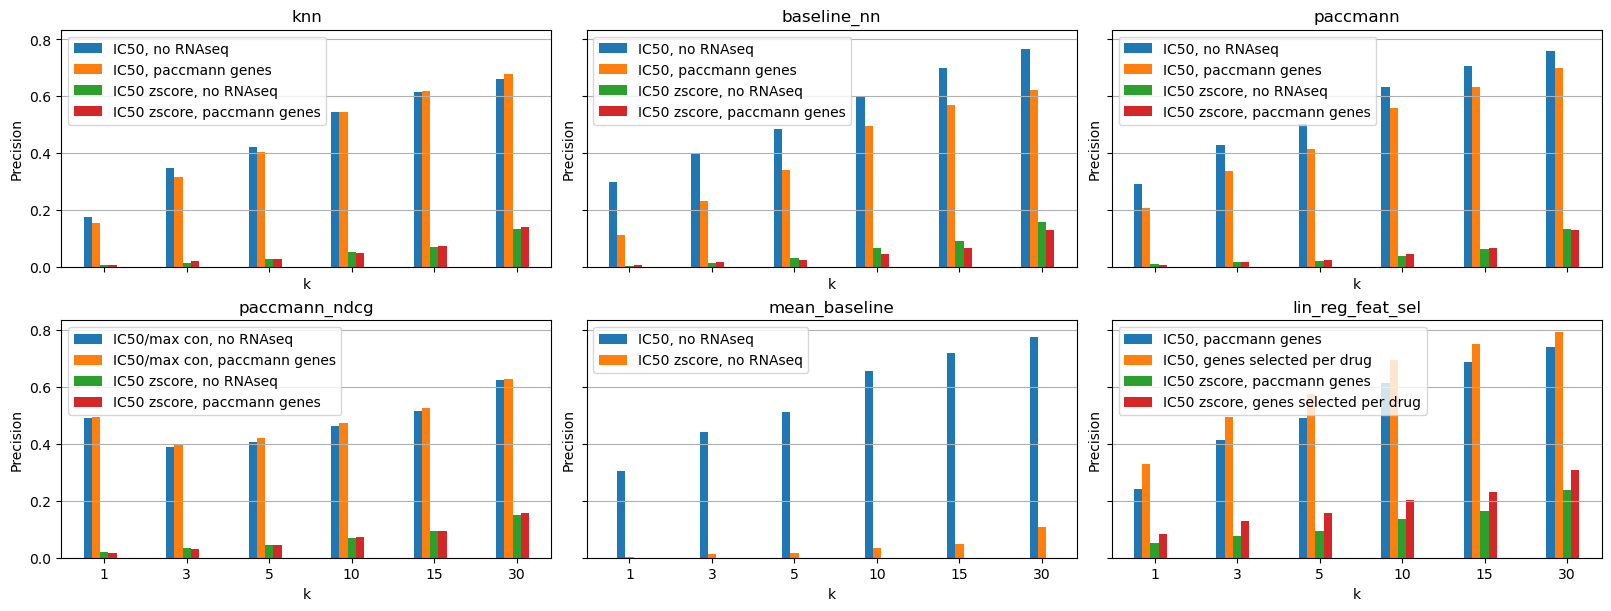

In [5]:

fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(16,6), constrained_layout=True, 
                        sharey=True, sharex=True)
axs = axs.ravel()

X = ks
X_axis = np.arange(len(X))

for i, model in enumerate(['knn', 'baseline_nn', 'paccmann']):
    model_ranking = ranking_res[ranking_res.model == model]
    
    axs[i].bar(X_axis - 0.2, model_ranking[(model_ranking.drug_response == 'IC50')&
                                           (model_ranking.genes == 'no RNAseq')].prec.values, 0.1, 
               label = 'IC50, no RNAseq')
    axs[i].bar(X_axis - 0.1, model_ranking[(model_ranking.drug_response == 'IC50')&
                                           (model_ranking.genes == 'paccmann genes')].prec.values, 0.1, label = 'IC50, paccmann genes')
    axs[i].bar(X_axis - 0, model_ranking[(model_ranking.drug_response == 'IC50_zscore')&
                                           (model_ranking.genes == 'no RNAseq')].prec.values, 0.1, label = 'IC50 zscore, no RNAseq')
    axs[i].bar(X_axis + 0.1, model_ranking[(model_ranking.drug_response == 'IC50_zscore')&
                                           (model_ranking.genes == 'paccmann genes')].prec.values, 0.1, label = 'IC50 zscore, paccmann genes')
    axs[i].set_title(model)
    axs[i].set_xticks(X_axis, X)
    axs[i].set_ylabel("Precision")
    axs[i].set_xlabel("k")
    axs[i].grid(axis='y')
    
    axs[i].legend(loc = 'upper left')

###
model = 'paccmann_ndcg'     
model_ranking = ranking_res[ranking_res.model == model]
    
axs[3].bar(X_axis - 0.2, model_ranking[(model_ranking.drug_response == 'IC50_max_conc')&
                                           (model_ranking.genes == 'no RNAseq')].prec.values, 0.1, label = 'IC50/max con, no RNAseq')
axs[3].bar(X_axis - 0.1, model_ranking[(model_ranking.drug_response == 'IC50_max_conc')&
                                           (model_ranking.genes == 'paccmann genes')].prec.values, 0.1, label = 'IC50/max con, paccmann genes')
axs[3].bar(X_axis - 0, model_ranking[(model_ranking.drug_response == 'IC50_zscore')&
                                           (model_ranking.genes == 'no RNAseq')].prec.values, 0.1, label = 'IC50 zscore, no RNAseq')
axs[3].bar(X_axis + 0.1, model_ranking[(model_ranking.drug_response == 'IC50_zscore')&
                                       (model_ranking.genes == 'paccmann genes')].prec.values, 0.1, label = 'IC50 zscore, paccmann genes')
axs[3].set_title(model)
axs[3].set_xticks(X_axis, X)
axs[3].set_ylabel("Precision")
axs[3].set_xlabel("k")
axs[3].grid(axis='y')
    
axs[3].legend(loc = 'upper left')

####

model = 'mean_baseline'
model_ranking = ranking_res[ranking_res.model == model]
    
axs[4].bar(X_axis - 0.1, model_ranking[(model_ranking.drug_response == 'IC50')&
                                           (model_ranking.genes == 'no RNAseq')].prec.values, 0.1, label = 'IC50, no RNAseq')
axs[4].bar(X_axis, model_ranking[(model_ranking.drug_response == 'IC50_zscore')&
                                           (model_ranking.genes == 'no RNAseq')].prec.values, 0.1, label = 'IC50 zscore, no RNAseq')
axs[4].set_title(model)
axs[4].set_xticks(X_axis, X)
axs[4].set_ylabel("Precision")
axs[4].set_xlabel("k")
axs[4].grid(axis='y')
axs[4].legend(loc = 'upper left')

####
model = 'lin_reg_feat_sel'
model_ranking = ranking_res[ranking_res.model == model]
    
axs[5].bar(X_axis - 0.2, model_ranking[(model_ranking.drug_response == 'IC50')&
                                           (model_ranking.genes == 'paccmann genes')].prec.values, 0.1, label = 'IC50, paccmann genes')
axs[5].bar(X_axis - 0.1, model_ranking[(model_ranking.drug_response == 'IC50')&
                                           (model_ranking.genes == 'genes selected per drug')].prec.values, 0.1, label = 'IC50, genes selected per drug')
axs[5].bar(X_axis - 0, model_ranking[(model_ranking.drug_response == 'IC50_zscore')&
                                           (model_ranking.genes == 'paccmann genes')].prec.values, 0.1, label = 'IC50 zscore, paccmann genes')
axs[5].bar(X_axis + 0.1, model_ranking[(model_ranking.drug_response == 'IC50_zscore')&
                                           (model_ranking.genes == 'genes selected per drug')].prec.values, 0.1, label = 'IC50 zscore, genes selected per drug')
axs[5].set_title(model)
axs[5].set_xticks(X_axis, X)
axs[5].set_ylabel("Precision")
axs[5].set_xlabel("k")
axs[5].grid(axis='y')
axs[5].legend(loc = 'upper left')

plt.savefig('figures/results/GDSC/GDSC_models_ranking.png', facecolor = 'white', transparent = False, dpi=500)

In [6]:
counter = 0
mse_pearson_res = pd.DataFrame(columns = ['model', 'drug_response', 'genes',
                                           'mse', 'mse_std', 'mse_stderror',
                                           'pearson', 'pearson_std', 'pearson_stderror', 'pval_mean'])

for (model, drug_response, genes), rows in mse_pearson_eval.groupby(['model', 'drug_response', 'genes']):
    mse_pearson_res.loc[counter] = [model, drug_response, genes, 
                              np.mean(rows.mse), np.std(rows.mse), np.std(rows.mse)/np.sqrt(len(rows.mse)),
                              np.mean(rows.pearson), np.std(rows.pearson), np.std(rows.pearson)/np.sqrt(len(rows.pearson)),
                              np.mean(rows.pval)
                            ]
    counter+=1
mse_pearson_res.to_csv('tables/results/GDSC/gdsc_mse_pearson_per_cell_line.csv')
mse_pearson_res

,model,drug_response,genes,mse,mse_std,mse_stderror,pearson,pearson_std,pearson_stderror,pval_mean
0,baseline_nn,IC50,no RNAseq,15.394007,2.948023,1.318396,0.877287,0.001985,0.000888,3.837127e-10
1,baseline_nn,IC50,paccmann genes,37.837053,13.317292,5.955674,0.693965,0.040466,0.018097,3.532910e-03
2,baseline_nn,IC50_zscore,no RNAseq,1.014737,0.026659,0.011922,-0.014516,0.011183,0.005001,2.838348e-01
3,baseline_nn,IC50_zscore,paccmann genes,4.587506,1.553524,0.694757,0.006504,0.002472,0.001105,3.573510e-01
4,knn,IC50,no RNAseq,3.687375,0.209334,0.093617,0.785572,0.009478,0.004239,1.577048e-08
5,knn,IC50,paccmann genes,3.697025,0.042615,0.019058,0.788795,0.005084,0.002274,2.567995e-09
6,knn,IC50_zscore,no RNAseq,1.927974,0.071832,0.032124,-0.002824,0.001690,0.000756,4.929709e-01
7,knn,IC50_zscore,paccmann genes,1.984143,0.022647,0.010128,0.007340,0.013076,0.005848,2.719243e-01
8,lin_reg_feat_sel,IC50,genes selected per drug,1.462895,0.028728,0.012848,0.906132,0.001116,0.000499,6.369366e-12
9,lin_reg_feat_sel,IC50,paccmann genes,2.289939,0.056963,0.025475,0.854974,0.003432,0.001535,3.515638e-09


In [7]:
def extract_metrics(mse_pearson, models):
    pearson = []
    pearson_err = []
    mse = []
    mse_err = []
    for model in models:
        row = mse_pearson[mse_pearson.model == model]
        if len(row) == 0:
            pearson.append(0)
            pearson_err.append(0)
            mse.append(0)
            mse_err.append(0)
        else:
            pearson.append(row.pearson.values[0])
            pearson_err.append(row.pearson_stderror.values[0])
            mse.append(row.mse.values[0])
            mse_err.append(row.mse_stderror.values[0])
    return (pearson, pearson_err, mse, mse_err)

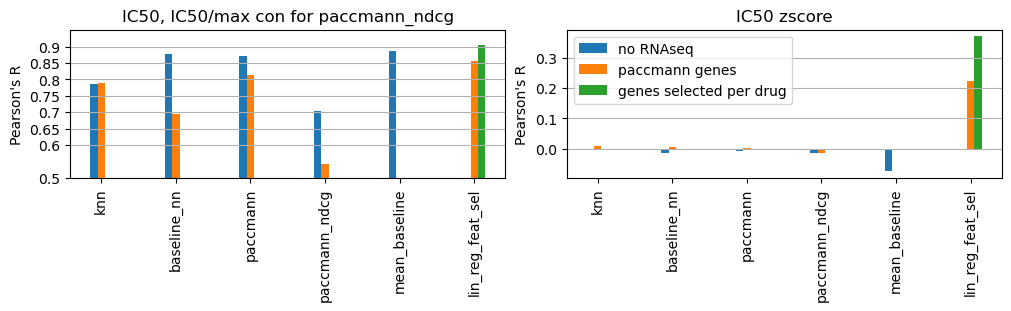

In [8]:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(10,3), constrained_layout=True)
axs = axs.ravel()

X = ['knn', 'baseline_nn', 'paccmann', 'paccmann_ndcg', 'mean_baseline', 'lin_reg_feat_sel']
X_axis = np.arange(len(X))

for i in [0, 1]:
    if i == 0: drug_response = ['IC50', 'IC50_max_conc']
    else: drug_response = ['IC50_zscore']

    rel_mse_pearson = mse_pearson_res[mse_pearson_res.drug_response.isin(drug_response)]

    (IC50_pearson, IC50_pearson_err, IC50_mse, IC50_mse_err) = extract_metrics(rel_mse_pearson[(rel_mse_pearson.genes == 'paccmann genes')], X)
    (IC50zero_pearson, IC50zero_pearson_err, IC50zero_mse, IC50zero_mse_err) = extract_metrics(rel_mse_pearson[(rel_mse_pearson.genes == 'no RNAseq')], X)
    (IC50sel_pearson, IC50sel_pearson_err, IC50sel_mse, IC50sel_mse_err) = extract_metrics(rel_mse_pearson[(rel_mse_pearson.genes == 'genes selected per drug')], X)

    axs[i].bar(X_axis - 0.1, IC50zero_pearson, 0.1, label = 'no RNAseq')
    axs[i].bar(X_axis - 0.0, IC50_pearson, 0.1, label = 'paccmann genes')
    axs[i].bar(X_axis + 0.1, IC50sel_pearson, 0.1, label = 'genes selected per drug')


    if i == 0:
        axs[i].set_title('IC50, IC50/max con for paccmann_ndcg')
        ylim = 0.5
        Y = [0.5, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9]
        axs[i].set_yticks(Y, Y)
        axs[i].set_ylim(ylim)
    elif i == 1: 
        axs[i].legend(loc = 'upper left')
        axs[i].set_title('IC50 zscore')
    
    axs[i].set_xticks(X_axis, X, rotation = 90)
    axs[i].grid(axis='y')
    axs[i].set_ylabel("Pearson's R")
plt.savefig('figures/results/GDSC/GDSC_models_pearson.png', facecolor = 'white', transparent = False, dpi=500)    

In [9]:
counter = 0
mse_pearson_res_per_drug = pd.DataFrame(columns = ['model', 'drug_response', 'genes',
                                           'mse', 'mse_std', 'mse_stderror',
                                           'pearson', 'pearson_std', 'pearson_stderror', 'pval_mean'])

for (model, drug_response, genes), rows in mse_pearson_eval_per_drug.groupby(['model', 'drug_response', 'genes']):
    mse_pearson_res_per_drug.loc[counter] = [model, drug_response, genes, 
                              np.mean(rows.mse), np.std(rows.mse), np.std(rows.mse)/np.sqrt(len(rows.mse)),
                              np.mean(rows.pearson), np.std(rows.pearson), 
                              np.std(rows.pearson)/np.sqrt(len(rows.pearson)),
                              np.mean(rows.pval)
                            ]
    counter+=1
mse_pearson_res_per_drug.to_csv('tables/results/GDSC/gdsc_mse_pearson_per_drug.csv')
mse_pearson_res_per_drug

,model,drug_response,genes,mse,mse_std,mse_stderror,pearson,pearson_std,pearson_stderror,pval_mean
0,baseline_nn,IC50,no RNAseq,15.662958,2.953430,1.320814,NaN,NaN,NaN,NaN
1,baseline_nn,IC50,paccmann genes,38.226099,13.190119,5.898801,-0.015097,0.020460,0.009150,0.507295
2,baseline_nn,IC50_zscore,no RNAseq,1.006597,0.019467,0.008706,NaN,NaN,NaN,NaN
3,baseline_nn,IC50_zscore,paccmann genes,4.629683,1.583856,0.708322,0.000391,0.011647,0.005209,0.531156
4,knn,IC50,no RNAseq,3.723531,0.191661,0.085713,NaN,NaN,NaN,NaN
5,knn,IC50,paccmann genes,3.732895,0.013347,0.005969,0.028888,0.010571,0.004727,0.497557
6,knn,IC50_zscore,no RNAseq,1.925890,0.064466,0.028830,NaN,NaN,NaN,NaN
7,knn,IC50_zscore,paccmann genes,1.974448,0.014254,0.006375,0.028937,0.010177,0.004551,0.497311
8,lin_reg_feat_sel,IC50,genes selected per drug,1.468096,0.023686,0.010593,0.461772,0.012129,0.005424,0.000346
9,lin_reg_feat_sel,IC50,paccmann genes,2.279505,0.045265,0.020243,0.305296,0.013643,0.006101,0.038302
